# Objective - To predict whether a customer will subscribe for a term deposit

Import relevant librares

In [80]:
import warnings
import os
import random
import pandas as pd
import numpy as np
import shap
import tensorflow
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import lazypredict
from lazypredict.Supervised import LazyClassifier
import matplotlib.pyplot as plt
import lightgbm
from lightgbm.sklearn import LGBMClassifier
from lightgbm.sklearn import LGBMRegressor
import xgboost
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.metrics import classification_report, r2_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')

Import data

In [2]:
os.chdir('F:\Blue Sky\EVERYTHING\DATA SCIENCE\Apziva\Term Deposit Marketing')
tdm = pd.read_csv('term-deposit-marketing-2020.csv')
tdm.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


## Exploratory Data Analysis

In [3]:
tdm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


Total rows are 40,000. There are no missing values and hence imputation is not requires

In [4]:
tdm.describe(include = 'all')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
count,40000.00,40000,40000,40000,40000,40000.00,40000,40000,40000,40000.00,40000,40000.00,40000.00,40000
unique,nan,12,3,4,2,nan,2,2,3,nan,11,nan,nan,2
top,nan,blue-collar,married,secondary,no,nan,yes,no,cellular,nan,may,nan,nan,no
freq,nan,9383,24386,20993,39191,nan,24031,33070,24914,nan,13532,nan,nan,37104
mean,40.54,NaN,NaN,NaN,NaN,1274.28,NaN,NaN,NaN,16.02,NaN,254.82,2.88,NaN
std,9.64,NaN,NaN,NaN,NaN,2903.77,NaN,NaN,NaN,8.28,NaN,259.37,3.24,NaN
min,19.00,NaN,NaN,NaN,NaN,-8019.00,NaN,NaN,NaN,1.00,NaN,0.00,1.00,NaN
25%,33.00,NaN,NaN,NaN,NaN,54.00,NaN,NaN,NaN,8.00,NaN,100.00,1.00,NaN
50%,39.00,NaN,NaN,NaN,NaN,407.00,NaN,NaN,NaN,17.00,NaN,175.00,2.00,NaN
75%,48.00,NaN,NaN,NaN,NaN,1319.00,NaN,NaN,NaN,21.00,NaN,313.00,3.00,NaN


Convert categorical data into numeric using dummy variables

In [5]:
tdm_job = pd.get_dummies(tdm['job'], prefix = 'job', prefix_sep = '_', drop_first = True)
tdm_marital = pd.get_dummies(tdm['marital'], prefix = 'marital', prefix_sep = '_', drop_first = True)
tdm_education = pd.get_dummies(tdm['education'], prefix = 'education', prefix_sep = '_', drop_first = True)
tdm_default = pd.get_dummies(tdm['default'], prefix = 'default', prefix_sep = '_', drop_first = True)
tdm_housing = pd.get_dummies(tdm['housing'], prefix = 'housing', prefix_sep = '_', drop_first = True)
tdm_loan = pd.get_dummies(tdm['loan'], prefix = 'loan', prefix_sep = '_', drop_first = True)
tdm_contact = pd.get_dummies(tdm['contact'], prefix = 'contact', prefix_sep = '_', drop_first = True)
tdm_month = pd.get_dummies(tdm['month'], prefix = 'month', prefix_sep = '_', drop_first = True)
tdm_y = pd.get_dummies(tdm['y'], prefix = 'y', prefix_sep = '_', drop_first = True)

In [6]:
# Concat original data frame and dummy columns
tdm_dc = tdm.drop(columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'y'])
tdm_dc = pd.concat([tdm_dc, tdm_job, tdm_marital, tdm_education, tdm_default, tdm_housing, tdm_loan, tdm_contact, tdm_month, tdm_y], axis = 1)
tdm_dc.head()

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,y_yes
0,58,2143,5,261,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,44,29,5,151,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,33,2,5,76,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,47,1506,5,92,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,33,1,5,198,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


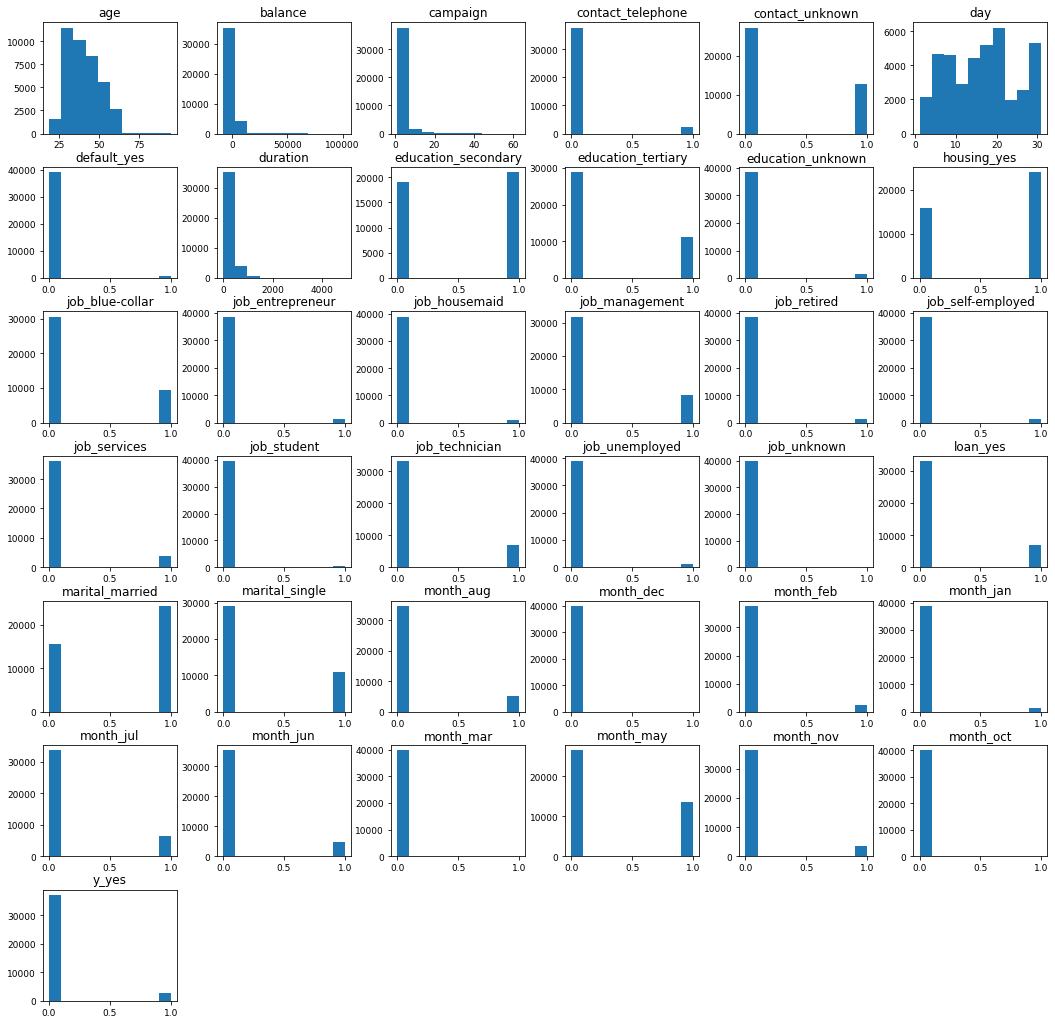

In [7]:
# Visualize numerical features using histogramsb
tdm_dc.hist(figsize = (18,18), grid = False, xlabelsize=9, ylabelsize=9)
plt.show()

Here are some observations from the above graphs
- The company targets young blue collar workers primarily having having low or negative balance. Usually blue collar people earn less income and that would explain the negative balance.
- Most of the calls are in the summer months and peaking in May.

Check class balancing

In [8]:
tdm_dc['y_yes'].value_counts()

0    37104
1     2896
Name: y_yes, dtype: int64

The class is heavily skewed towards 'no' which is not surprising. Only a fraction of people will generally subscribe to a term deposit. We'll need to balance our class to make our analysis robust.

Set seed for reproducability

In [9]:
seed_value = 42
random.seed(seed_value)

Make dataframes for X and y

In [10]:
X = tdm_dc.drop(columns = ['y_yes'])
y = tdm_dc['y_yes']

Split data for train and test

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed_value)

In [12]:
# Check shape of train and test data
print(X_train.shape)           
print(X_test.shape)

(32000, 36)
(8000, 36)


## Class balancing

We'll try different class balancing techniques like oversampling and undersampling. Oversampling will ensure that we don't lose out on majority of the valuable data which has class value as 'no'. We'll experiment with two types of oversampling methods: RandomOverSampler and SMOTE. SMOTE is a smarter way to oversample the imbalanced data.

### a. Oversampling - RandomOverSampler

In [13]:
ros = RandomOverSampler(random_state = seed_value)     # Create an instance of RandomOverSampler
X_ros, y_ros = ros.fit_resample(X_train, y_train)      # Resample the training data

In [14]:
pd.value_counts(y_ros)                                 # Get counts after class balancing

1    29680
0    29680
Name: y_yes, dtype: int64

The class is now balanced as counts for both classes are same.

Lets start with building models using Lazypredict to get an idea of how the models perform. It is an easy way to get F1 score for a large number of models.

In [15]:
# Get classifier list from lazypredict.Supervised.CLASSIFIERS. We removed LabelSpreading and LabelPropogation models 
# as they were consuming too much RAM.
classifiers = [('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('KNeighborsClassifier',
  sklearn.neighbors._classification.KNeighborsClassifier),
 ('LinearDiscriminantAnalysis',
  sklearn.discriminant_analysis.LinearDiscriminantAnalysis),
 ('LinearSVC', sklearn.svm._classes.LinearSVC),
 ('LogisticRegression', sklearn.linear_model._logistic.LogisticRegression),
 ('NearestCentroid', sklearn.neighbors._nearest_centroid.NearestCentroid),
 ('NuSVC', sklearn.svm._classes.NuSVC),
 ('PassiveAggressiveClassifier',
  sklearn.linear_model._passive_aggressive.PassiveAggressiveClassifier),
 ('Perceptron', sklearn.linear_model._perceptron.Perceptron),
 ('QuadraticDiscriminantAnalysis',
  sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis),
 ('RandomForestClassifier', sklearn.ensemble._forest.RandomForestClassifier),
 ('RidgeClassifier', sklearn.linear_model._ridge.RidgeClassifier),
 ('RidgeClassifierCV', sklearn.linear_model._ridge.RidgeClassifierCV),
 ('SGDClassifier', sklearn.linear_model._stochastic_gradient.SGDClassifier),
 ('SVC', sklearn.svm._classes.SVC),
 ('StackingClassifier', sklearn.ensemble._stacking.StackingClassifier),
 ('XGBClassifier', xgboost.sklearn.XGBClassifier),
 ('LGBMClassifier', lightgbm.sklearn.LGBMClassifier)]

In [16]:
# Assign new classifier list to lazypredict.Supervised.CLASSIFIERS
lazypredict.Supervised.CLASSIFIERS = classifiers

In [17]:
lzy_o = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)      # Create an instance of LazyClassifier
models_o, predictions_o = lzy_o.fit(X_ros, X_test, y_ros, y_test)                # Fit model with training data and make predictions

  4%|███                                                                                | 1/27 [00:05<02:27,  5.65s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.875375, 'Balanced Accuracy': 0.8663942768199233, 'ROC AUC': 0.8663942768199233, 'F1 Score': 0.8977935964293196, 'Time taken': 5.653932332992554}


  7%|██████▏                                                                            | 2/27 [00:11<02:18,  5.55s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.931625, 'Balanced Accuracy': 0.7141403256704981, 'ROC AUC': 0.714140325670498, 'F1 Score': 0.9294160743814535, 'Time taken': 5.415879726409912}


 11%|█████████▏                                                                         | 3/27 [00:11<01:18,  3.26s/it]

{'Model': 'BernoulliNB', 'Accuracy': 0.834375, 'Balanced Accuracy': 0.8394995210727969, 'ROC AUC': 0.839499521072797, 'F1 Score': 0.8687584231920917, 'Time taken': 0.5230364799499512}


 15%|████████████▎                                                                      | 4/27 [01:37<13:41, 35.70s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.871, 'Balanced Accuracy': 0.8720441211685823, 'ROC AUC': 0.8720441211685823, 'F1 Score': 0.8949476879554895, 'Time taken': 85.41352319717407}


 22%|██████████████████▍                                                                | 6/27 [01:38<05:23, 15.38s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.91825, 'Balanced Accuracy': 0.6701014727011494, 'ROC AUC': 0.6701014727011494, 'F1 Score': 0.9161686298675834, 'Time taken': 0.7887752056121826}


 26%|█████████████████████▌                                                             | 7/27 [01:38<03:28, 10.44s/it]

{'Model': 'DummyClassifier', 'Accuracy': 0.496, 'Balanced Accuracy': 0.5034497725095786, 'ROC AUC': 0.5034497725095786, 'F1 Score': 0.6083372494034699, 'Time taken': 0.2634124755859375}


 30%|████████████████████████▌                                                          | 8/27 [01:38<02:17,  7.22s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.906125, 'Balanced Accuracy': 0.6299389367816092, 'ROC AUC': 0.6299389367816093, 'F1 Score': 0.9042766709348545, 'Time taken': 0.3239121437072754}


 33%|███████████████████████████▋                                                       | 9/27 [01:48<02:24,  8.00s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.937375, 'Balanced Accuracy': 0.6315627993295019, 'ROC AUC': 0.6315627993295019, 'F1 Score': 0.9252266089328309, 'Time taken': 9.729934692382812}


 37%|██████████████████████████████▎                                                   | 10/27 [01:48<01:36,  5.65s/it]

{'Model': 'GaussianNB', 'Accuracy': 0.137875, 'Balanced Accuracy': 0.5314894636015326, 'ROC AUC': 0.5314894636015326, 'F1 Score': 0.1342567774462265, 'Time taken': 0.3698537349700928}


 41%|█████████████████████████████████▍                                                | 11/27 [03:03<07:10, 26.89s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.891125, 'Balanced Accuracy': 0.7443651221264367, 'ROC AUC': 0.7443651221264367, 'F1 Score': 0.9031751047386654, 'Time taken': 75.06040406227112}


 44%|████████████████████████████████████▍                                             | 12/27 [03:04<04:45, 19.05s/it]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.882125, 'Balanced Accuracy': 0.860422653256705, 'ROC AUC': 0.860422653256705, 'F1 Score': 0.902272925284836, 'Time taken': 1.1093039512634277}


 48%|███████████████████████████████████████▍                                          | 13/27 [03:38<05:26, 23.29s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.873375, 'Balanced Accuracy': 0.871722341954023, 'ROC AUC': 0.8717223419540229, 'F1 Score': 0.8965840245353274, 'Time taken': 33.06059956550598}


 52%|██████████████████████████████████████████▌                                       | 14/27 [03:38<03:35, 16.55s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.872, 'Balanced Accuracy': 0.8709815014367817, 'ROC AUC': 0.8709815014367815, 'F1 Score': 0.8956062194759948, 'Time taken': 0.9826481342315674}


 56%|█████████████████████████████████████████████▌                                    | 15/27 [03:39<02:20, 11.68s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.825875, 'Balanced Accuracy': 0.8012901101532567, 'ROC AUC': 0.8012901101532567, 'F1 Score': 0.8618273163440782, 'Time taken': 0.36299943923950195}


 59%|████████████████████████████████████████████████                                 | 16/27 [10:11<23:09, 126.33s/it]

{'Model': 'NuSVC', 'Accuracy': 0.87275, 'Balanced Accuracy': 0.8697841834291188, 'ROC AUC': 0.8697841834291188, 'F1 Score': 0.8960867930696307, 'Time taken': 392.59716415405273}


 63%|███████████████████████████████████████████████████▋                              | 17/27 [10:12<14:44, 88.49s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.814125, 'Balanced Accuracy': 0.7645324473180077, 'ROC AUC': 0.7645324473180077, 'F1 Score': 0.8527380567087142, 'Time taken': 0.48105525970458984}


 67%|██████████████████████████████████████████████████████▋                           | 18/27 [10:12<09:18, 62.01s/it]

{'Model': 'Perceptron', 'Accuracy': 0.8285, 'Balanced Accuracy': 0.8387362308429118, 'ROC AUC': 0.8387362308429119, 'F1 Score': 0.8647104337631889, 'Time taken': 0.35372066497802734}


 70%|█████████████████████████████████████████████████████████▋                        | 19/27 [10:13<05:48, 43.54s/it]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.075875, 'Balanced Accuracy': 0.5012871168582376, 'ROC AUC': 0.5012871168582375, 'F1 Score': 0.017656742639225512, 'Time taken': 0.5168085098266602}


 74%|████████████████████████████████████████████████████████████▋                     | 20/27 [10:22<03:51, 33.13s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.933625, 'Balanced Accuracy': 0.7032073156130269, 'ROC AUC': 0.7032073156130267, 'F1 Score': 0.9299983226893938, 'Time taken': 8.870417833328247}


 78%|███████████████████████████████████████████████████████████████▊                  | 21/27 [10:22<02:19, 23.31s/it]

{'Model': 'RidgeClassifier', 'Accuracy': 0.882125, 'Balanced Accuracy': 0.860422653256705, 'ROC AUC': 0.860422653256705, 'F1 Score': 0.902272925284836, 'Time taken': 0.41939520835876465}


 81%|██████████████████████████████████████████████████████████████████▊               | 22/27 [10:23<01:22, 16.50s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.882125, 'Balanced Accuracy': 0.860422653256705, 'ROC AUC': 0.860422653256705, 'F1 Score': 0.902272925284836, 'Time taken': 0.6018354892730713}


 85%|█████████████████████████████████████████████████████████████████████▊            | 23/27 [10:24<00:47, 11.81s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.852875, 'Balanced Accuracy': 0.8654813218390804, 'ROC AUC': 0.8654813218390804, 'F1 Score': 0.8822243706346601, 'Time taken': 0.8816499710083008}


 89%|████████████████████████████████████████████████████████████████████████▉         | 24/27 [13:38<03:19, 66.54s/it]

{'Model': 'SVC', 'Accuracy': 0.88475, 'Balanced Accuracy': 0.8634383979885057, 'ROC AUC': 0.8634383979885056, 'F1 Score': 0.9042085975633192, 'Time taken': 194.1988170146942}


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 26/27 [13:48<00:38, 38.25s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.90675, 'Balanced Accuracy': 0.8504699473180077, 'ROC AUC': 0.8504699473180077, 'F1 Score': 0.9192042065251823, 'Time taken': 10.494904279708862}


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [13:50<00:00, 30.76s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.88775, 'Balanced Accuracy': 0.8938802083333333, 'ROC AUC': 0.8938802083333333, 'F1 Score': 0.907349608401734, 'Time taken': 1.8665947914123535}


In [18]:
models_o

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.89,0.89,0.89,0.91,1.87
CalibratedClassifierCV,0.87,0.87,0.87,0.89,85.41
LinearSVC,0.87,0.87,0.87,0.90,33.06
LogisticRegression,0.87,0.87,0.87,0.90,0.98
NuSVC,0.87,0.87,0.87,0.90,392.60
AdaBoostClassifier,0.88,0.87,0.87,0.90,5.65
SGDClassifier,0.85,0.87,0.87,0.88,0.88
SVC,0.88,0.86,0.86,0.90,194.20
RidgeClassifier,0.88,0.86,0.86,0.90,0.42


### b. Oversampling - SMOTE

In [19]:
smo = SMOTE(random_state = seed_value)                      # Create an instance of SMOTE
X_smo, y_smo = smo.fit_resample(X_train, y_train)           # Resample the training data

In [20]:
pd.value_counts(y_smo)                                      # Get counts after class balancing

1    29680
0    29680
Name: y_yes, dtype: int64

In [21]:
lzy_smo = LazyClassifier(verbose=1, ignore_warnings=True, custom_metric=None)      # Create an instance of LazyClassifier
models_smo ,predictions_smo = lzy_smo.fit(X_smo, X_test, y_smo, y_test)            # Fit model with training data and make predictions

  4%|███                                                                                | 1/27 [00:03<01:39,  3.82s/it]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.91675, 'Balanced Accuracy': 0.7325490900383143, 'ROC AUC': 0.7325490900383141, 'F1 Score': 0.9200674930895457, 'Time taken': 3.8238563537597656}


  7%|██████▏                                                                            | 2/27 [00:08<01:46,  4.26s/it]

{'Model': 'BaggingClassifier', 'Accuracy': 0.925375, 'Balanced Accuracy': 0.7003636853448276, 'ROC AUC': 0.7003636853448275, 'F1 Score': 0.9237743505635494, 'Time taken': 4.557257413864136}


 11%|█████████▏                                                                         | 3/27 [00:08<00:58,  2.43s/it]

{'Model': 'BernoulliNB', 'Accuracy': 0.917625, 'Balanced Accuracy': 0.6673626077586207, 'ROC AUC': 0.6673626077586207, 'F1 Score': 0.9154906423749236, 'Time taken': 0.25110650062561035}


 19%|███████████████▎                                                                   | 5/27 [00:57<04:50, 13.19s/it]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.926375, 'Balanced Accuracy': 0.6920947078544062, 'ROC AUC': 0.6920947078544061, 'F1 Score': 0.9237905942469424, 'Time taken': 48.2983980178833}


 26%|█████████████████████▌                                                             | 7/27 [00:58<02:01,  6.09s/it]

{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.909125, 'Balanced Accuracy': 0.7100245450191571, 'ROC AUC': 0.7100245450191571, 'F1 Score': 0.9131869103955793, 'Time taken': 0.7427699565887451}
{'Model': 'DummyClassifier', 'Accuracy': 0.496, 'Balanced Accuracy': 0.5034497725095786, 'ROC AUC': 0.5034497725095786, 'F1 Score': 0.6083372494034699, 'Time taken': 0.1921992301940918}


 30%|████████████████████████▌                                                          | 8/27 [00:58<01:20,  4.25s/it]

{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.897, 'Balanced Accuracy': 0.676267660440613, 'ROC AUC': 0.6762676604406129, 'F1 Score': 0.9025329970812435, 'Time taken': 0.2740786075592041}


 33%|███████████████████████████▋                                                       | 9/27 [01:06<01:37,  5.39s/it]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.929625, 'Balanced Accuracy': 0.6586147030651341, 'ROC AUC': 0.6586147030651341, 'F1 Score': 0.9229112631563812, 'Time taken': 7.910831928253174}


 37%|██████████████████████████████▎                                                   | 10/27 [01:06<01:04,  3.81s/it]

{'Model': 'GaussianNB', 'Accuracy': 0.599625, 'Balanced Accuracy': 0.5905097581417624, 'ROC AUC': 0.5905097581417625, 'F1 Score': 0.6953604702262187, 'Time taken': 0.26180148124694824}


 41%|█████████████████████████████████▍                                                | 11/27 [02:04<05:26, 20.40s/it]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.919, 'Balanced Accuracy': 0.6472850814176245, 'ROC AUC': 0.6472850814176245, 'F1 Score': 0.9144502121209916, 'Time taken': 58.01464223861694}


 44%|████████████████████████████████████▍                                             | 12/27 [02:05<03:36, 14.40s/it]

{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.9175, 'Balanced Accuracy': 0.6184521671455938, 'ROC AUC': 0.6184521671455939, 'F1 Score': 0.9102598102763545, 'Time taken': 0.6934077739715576}


 48%|███████████████████████████████████████▍                                          | 13/27 [02:19<03:19, 14.22s/it]

{'Model': 'LinearSVC', 'Accuracy': 0.92325, 'Balanced Accuracy': 0.7144321719348659, 'ROC AUC': 0.7144321719348659, 'F1 Score': 0.9233724445886587, 'Time taken': 13.803860425949097}


 52%|██████████████████████████████████████████▌                                       | 14/27 [02:19<02:10, 10.06s/it]

{'Model': 'LogisticRegression', 'Accuracy': 0.92375, 'Balanced Accuracy': 0.7187051005747127, 'ROC AUC': 0.7187051005747127, 'F1 Score': 0.9240524039430787, 'Time taken': 0.44660019874572754}


 56%|█████████████████████████████████████████████▌                                    | 15/27 [02:19<01:25,  7.10s/it]

{'Model': 'NearestCentroid', 'Accuracy': 0.913875, 'Balanced Accuracy': 0.678153436302682, 'ROC AUC': 0.678153436302682, 'F1 Score': 0.9139094478044366, 'Time taken': 0.2301192283630371}


 59%|████████████████████████████████████████████████                                 | 16/27 [08:47<22:17, 121.63s/it]

{'Model': 'NuSVC', 'Accuracy': 0.920375, 'Balanced Accuracy': 0.5455355004789272, 'ROC AUC': 0.5455355004789272, 'F1 Score': 0.9009409348842907, 'Time taken': 387.6055061817169}


 63%|███████████████████████████████████████████████████▋                              | 17/27 [08:47<14:11, 85.16s/it]

{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.9035, 'Balanced Accuracy': 0.7278122006704981, 'ROC AUC': 0.727812200670498, 'F1 Score': 0.9105634913478836, 'Time taken': 0.3389303684234619}


 67%|██████████████████████████████████████████████████████▋                           | 18/27 [08:48<08:57, 59.70s/it]

{'Model': 'Perceptron', 'Accuracy': 0.8795, 'Balanced Accuracy': 0.6828529094827587, 'ROC AUC': 0.6828529094827586, 'F1 Score': 0.891655570312119, 'Time taken': 0.4242842197418213}


 70%|█████████████████████████████████████████████████████████▋                        | 19/27 [08:48<05:35, 41.91s/it]

{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.35725, 'Balanced Accuracy': 0.5391897150383143, 'ROC AUC': 0.5391897150383143, 'F1 Score': 0.46081851473189206, 'Time taken': 0.4842848777770996}


 74%|████████████████████████████████████████████████████████████▋                     | 20/27 [08:57<03:44, 32.14s/it]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.9315, 'Balanced Accuracy': 0.7100694444444444, 'ROC AUC': 0.7100694444444444, 'F1 Score': 0.9289988532282678, 'Time taken': 9.346187114715576}


 78%|███████████████████████████████████████████████████████████████▊                  | 21/27 [08:58<02:15, 22.57s/it]

{'Model': 'RidgeClassifier', 'Accuracy': 0.9175, 'Balanced Accuracy': 0.6184521671455938, 'ROC AUC': 0.6184521671455939, 'F1 Score': 0.9102598102763545, 'Time taken': 0.28240227699279785}


 81%|██████████████████████████████████████████████████████████████████▊               | 22/27 [08:58<01:20, 16.00s/it]

{'Model': 'RidgeClassifierCV', 'Accuracy': 0.9175, 'Balanced Accuracy': 0.6184521671455938, 'ROC AUC': 0.6184521671455939, 'F1 Score': 0.9102598102763545, 'Time taken': 0.6681251525878906}


 85%|█████████████████████████████████████████████████████████████████████▊            | 23/27 [08:59<00:45, 11.36s/it]

{'Model': 'SGDClassifier', 'Accuracy': 0.921375, 'Balanced Accuracy': 0.7030127514367817, 'ROC AUC': 0.7030127514367817, 'F1 Score': 0.9211531864794911, 'Time taken': 0.528594970703125}


 89%|████████████████████████████████████████████████████████████████████████▉         | 24/27 [10:04<01:22, 27.54s/it]

{'Model': 'SVC', 'Accuracy': 0.932, 'Balanced Accuracy': 0.7159437859195402, 'ROC AUC': 0.7159437859195403, 'F1 Score': 0.929834658343361, 'Time taken': 65.29525399208069}


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 26/27 [10:12<00:16, 16.72s/it]

{'Model': 'XGBClassifier', 'Accuracy': 0.926125, 'Balanced Accuracy': 0.7432052203065134, 'ROC AUC': 0.7432052203065134, 'F1 Score': 0.9275097240575755, 'Time taken': 8.210760116577148}


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [10:14<00:00, 22.75s/it]

{'Model': 'LGBMClassifier', 'Accuracy': 0.935, 'Balanced Accuracy': 0.7816166786398467, 'ROC AUC': 0.7816166786398467, 'F1 Score': 0.9365235247465711, 'Time taken': 1.480285406112671}


In [22]:
models_smo

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.94,0.78,0.78,0.94,1.48
XGBClassifier,0.93,0.74,0.74,0.93,8.21
AdaBoostClassifier,0.92,0.73,0.73,0.92,3.82
PassiveAggressiveClassifier,0.90,0.73,0.73,0.91,0.34
LogisticRegression,0.92,0.72,0.72,0.92,0.45
SVC,0.93,0.72,0.72,0.93,65.30
LinearSVC,0.92,0.71,0.71,0.92,13.80
RandomForestClassifier,0.93,0.71,0.71,0.93,9.35
DecisionTreeClassifier,0.91,0.71,0.71,0.91,0.74


### c. Undersampling

In [23]:
rus = RandomUnderSampler(random_state = seed_value)               # Create an instance of RandomUnderSampler
X_rus, y_rus = rus.fit_resample(X_train, y_train)                 # Resample training data

In [24]:
pd.value_counts(y_rus)                                            # Check value counts after rebalancing

1    2320
0    2320
Name: y_yes, dtype: int64

The classes is now balanced as both classes have equal counts.

In [25]:
lzy_u = LazyClassifier(verbose = 1, ignore_warnings = True, custom_metric = None)     # Create an instance of LazyClassifier
models_u, predictions_u = lzy_u.fit(X_rus, X_test, y_rus, y_test)                     # Fit model with training data and make predictions

  4%|███                                                                                | 1/27 [00:00<00:13,  1.86it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.876625, 'Balanced Accuracy': 0.8638649425287357, 'ROC AUC': 0.8638649425287357, 'F1 Score': 0.8985742666235176, 'Time taken': 0.5382215976715088}


  7%|██████▏                                                                            | 2/27 [00:00<00:11,  2.17it/s]

{'Model': 'BaggingClassifier', 'Accuracy': 0.8625, 'Balanced Accuracy': 0.8618594348659003, 'ROC AUC': 0.8618594348659004, 'F1 Score': 0.8887448851260208, 'Time taken': 0.4082486629486084}
{'Model': 'BernoulliNB', 'Accuracy': 0.831625, 'Balanced Accuracy': 0.8380178400383143, 'ROC AUC': 0.8380178400383141, 'F1 Score': 0.8668324441125772, 'Time taken': 0.0514833927154541}


 22%|██████████████████▍                                                                | 6/27 [00:03<00:09,  2.11it/s]

{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.87325, 'Balanced Accuracy': 0.8724556992337165, 'ROC AUC': 0.8724556992337164, 'F1 Score': 0.8965213623802597, 'Time taken': 2.112241506576538}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.81875, 'Balanced Accuracy': 0.8102625119731801, 'ROC AUC': 0.8102625119731801, 'F1 Score': 0.8572486167007612, 'Time taken': 0.08149099349975586}
{'Model': 'DummyClassifier', 'Accuracy': 0.496, 'Balanced Accuracy': 0.5034497725095786, 'ROC AUC': 0.5034497725095786, 'F1 Score': 0.6083372494034699, 'Time taken': 0.050662994384765625}
{'Model': 'ExtraTreeClassifier', 'Accuracy': 0.764875, 'Balanced Accuracy': 0.7500074832375478, 'ROC AUC': 0.7500074832375478, 'F1 Score': 0.8188073021303063, 'Time taken': 0.04893994331359863}


 33%|███████████████████████████▋                                                       | 9/27 [00:04<00:07,  2.46it/s]

{'Model': 'ExtraTreesClassifier', 'Accuracy': 0.85725, 'Balanced Accuracy': 0.862233596743295, 'ROC AUC': 0.862233596743295, 'F1 Score': 0.8851394953132069, 'Time taken': 0.9254708290100098}
{'Model': 'GaussianNB', 'Accuracy': 0.922125, 'Balanced Accuracy': 0.5753038194444444, 'ROC AUC': 0.5753038194444444, 'F1 Score': 0.9071473755149402, 'Time taken': 0.05049300193786621}


 41%|█████████████████████████████████▍                                                | 11/27 [00:07<00:12,  1.28it/s]

{'Model': 'KNeighborsClassifier', 'Accuracy': 0.796625, 'Balanced Accuracy': 0.7591071000957854, 'ROC AUC': 0.7591071000957854, 'F1 Score': 0.8407689191585589, 'Time taken': 3.071946620941162}
{'Model': 'LinearDiscriminantAnalysis', 'Accuracy': 0.8815, 'Balanced Accuracy': 0.8608866139846744, 'ROC AUC': 0.8608866139846744, 'F1 Score': 0.901854917921778, 'Time taken': 0.08058929443359375}


 56%|█████████████████████████████████████████████▌                                    | 15/27 [00:08<00:05,  2.13it/s]

{'Model': 'LinearSVC', 'Accuracy': 0.8755, 'Balanced Accuracy': 0.8736679837164751, 'ROC AUC': 0.873667983716475, 'F1 Score': 0.8981234285714286, 'Time taken': 0.6754498481750488}
{'Model': 'LogisticRegression', 'Accuracy': 0.873375, 'Balanced Accuracy': 0.8701209291187739, 'ROC AUC': 0.8701209291187739, 'F1 Score': 0.8965312481260139, 'Time taken': 0.08222174644470215}
{'Model': 'NearestCentroid', 'Accuracy': 0.829875, 'Balanced Accuracy': 0.8106516403256705, 'ROC AUC': 0.8106516403256705, 'F1 Score': 0.8648304628256862, 'Time taken': 0.04687213897705078}


 67%|██████████████████████████████████████████████████████▋                           | 18/27 [00:10<00:05,  1.77it/s]

{'Model': 'NuSVC', 'Accuracy': 0.862, 'Balanced Accuracy': 0.8663942768199233, 'ROC AUC': 0.8663942768199233, 'F1 Score': 0.8885438757429911, 'Time taken': 2.4586100578308105}
{'Model': 'PassiveAggressiveClassifier', 'Accuracy': 0.8095, 'Balanced Accuracy': 0.7812574832375478, 'ROC AUC': 0.7812574832375478, 'F1 Score': 0.8501280859368794, 'Time taken': 0.0518646240234375}
{'Model': 'Perceptron', 'Accuracy': 0.837625, 'Balanced Accuracy': 0.8084216355363985, 'ROC AUC': 0.8084216355363983, 'F1 Score': 0.8700165313971313, 'Time taken': 0.05690813064575195}
{'Model': 'QuadraticDiscriminantAnalysis', 'Accuracy': 0.9275, 'Balanced Accuracy': 0.5445701628352491, 'ROC AUC': 0.5445701628352492, 'F1 Score': 0.9044924789033201, 'Time taken': 0.08442544937133789}


 81%|██████████████████████████████████████████████████████████████████▊               | 22/27 [00:11<00:01,  2.57it/s]

{'Model': 'RandomForestClassifier', 'Accuracy': 0.86625, 'Balanced Accuracy': 0.8854989822796935, 'ROC AUC': 0.8854989822796935, 'F1 Score': 0.8920733879800169, 'Time taken': 0.9068706035614014}
{'Model': 'RidgeClassifier', 'Accuracy': 0.8815, 'Balanced Accuracy': 0.8608866139846744, 'ROC AUC': 0.8608866139846744, 'F1 Score': 0.901854917921778, 'Time taken': 0.05094265937805176}
{'Model': 'RidgeClassifierCV', 'Accuracy': 0.88175, 'Balanced Accuracy': 0.8610213122605364, 'ROC AUC': 0.8610213122605364, 'F1 Score': 0.9020335182577225, 'Time taken': 0.07262110710144043}
{'Model': 'SGDClassifier', 'Accuracy': 0.85375, 'Balanced Accuracy': 0.858746408045977, 'ROC AUC': 0.858746408045977, 'F1 Score': 0.88262314094665, 'Time taken': 0.09061193466186523}


 89%|████████████████████████████████████████████████████████████████████████▉         | 24/27 [00:13<00:01,  1.72it/s]

{'Model': 'SVC', 'Accuracy': 0.860875, 'Balanced Accuracy': 0.8713930795019158, 'ROC AUC': 0.8713930795019156, 'F1 Score': 0.8879222665364546, 'Time taken': 1.9251954555511475}


 96%|██████████████████████████████████████████████████████████████████████████████▉   | 26/27 [00:14<00:00,  1.92it/s]

{'Model': 'XGBClassifier', 'Accuracy': 0.86825, 'Balanced Accuracy': 0.8929822198275862, 'ROC AUC': 0.8929822198275862, 'F1 Score': 0.8936872438606895, 'Time taken': 0.7720274925231934}


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:15<00:00,  1.78it/s]

{'Model': 'LGBMClassifier', 'Accuracy': 0.869625, 'Balanced Accuracy': 0.8945237667624522, 'ROC AUC': 0.8945237667624523, 'F1 Score': 0.8946903378526866, 'Time taken': 0.4239811897277832}


In [26]:
models_u

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.87,0.89,0.89,0.89,0.42
XGBClassifier,0.87,0.89,0.89,0.89,0.77
RandomForestClassifier,0.87,0.89,0.89,0.89,0.91
LinearSVC,0.88,0.87,0.87,0.90,0.68
CalibratedClassifierCV,0.87,0.87,0.87,0.90,2.11
SVC,0.86,0.87,0.87,0.89,1.93
LogisticRegression,0.87,0.87,0.87,0.90,0.08
NuSVC,0.86,0.87,0.87,0.89,2.46
AdaBoostClassifier,0.88,0.86,0.86,0.90,0.54


We see that the highest F1 score achieved is 94% when class balancing is done using SMOTE oversampling. We'll continue with SMOTE oversampling and build individual models for models with high F1 score.

# Modeling

Based on diversity, time taken to run and F1 score, we have selected the following models for individual modeling: LightGBM, Logistic Regression, Support Vector Machine, Stochastic Gradient Descent and Passive Aggressive Classifier. 

### Evaluation Metric - We have selected 'Recall for class 1' as our evaluation metric because the company would like to predict maximum number of people who would subscribe to a term deposit. 

Recall in our case is (subscribed customers predicted correctly)/(subscribed customers predicted correctly + subscribed customers predicted incorrectly).

We would like to minimize the number of subscribed customers predicted incorrectly as it would be a lost opportunity. And hence would like to maximize Recall.

### a. Light GBM

In [27]:
lgbm = LGBMClassifier()                                         # Create an instance of LGBMClassifier
lgbm.fit(X_smo, y_smo)                                          # Fit model with SMOTE oversampled training data
print(classification_report(y_test, lgbm.predict(X_test)))      # Generate classification report

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7424
           1       0.54      0.60      0.57       576

    accuracy                           0.93      8000
   macro avg       0.76      0.78      0.77      8000
weighted avg       0.94      0.93      0.94      8000



The F1 score using LGBMClassifier is 93% which is quite good. However, Recall for class 1 is only 60%. That is, our model is able to predict customers who will not subscribe to term deposit marketing with much greater accuracy but is unable to maintain high accuracy for people who will subscribe.

In [28]:
cross_val_score(lgbm, X_smo, y_smo, cv=5)

array([0.83600067, 0.9703504 , 0.9724562 , 0.97321429, 0.97456199])

The 5-fold cross validation indicates that accuracy should be in the range [0.83, 0.97]. Our F1 score of 0.93 fits in this range.

### b. Logistic Regression

In [29]:
logreg = LogisticRegression(random_state = seed_value)           # Create an instance of LogisticRegression
logreg.fit(X_smo, y_smo)                                         # Fit model with training data

LogisticRegression(random_state=42)

In [30]:
print(classification_report(y_test, logreg.predict(X_test)))     # Generate classification report

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7424
           1       0.34      0.59      0.43       576

    accuracy                           0.89      8000
   macro avg       0.65      0.75      0.69      8000
weighted avg       0.92      0.89      0.90      8000



The recall for class 1 has dropped slightly to 59% compared to 60% for LightGBM.

In [31]:
cross_val_score(logreg, X_smo, y_smo, cv=5)                      # Generate cross validation report

array([0.84307615, 0.91610512, 0.91265162, 0.91391509, 0.92419137])

The F1 score of 89% fits in the cross validation range of [84%, 92%] based on 5-fold cross validation. 

### c. Support Vector Machine

In [32]:
svc = SVC()                                                     # Create an instance of SVC
svc.fit(X_smo, y_smo)                                           # Fit model with SMOTE oversampled training data
print(classification_report(y_test, svc.predict(X_test)))       # Generate classification report

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7424
           1       0.28      0.76      0.41       576

    accuracy                           0.84      8000
   macro avg       0.63      0.80      0.66      8000
weighted avg       0.93      0.84      0.87      8000



The F1 score for SVC is only 84% compared to 93% predicted by Lazypredict for the same model. This is much lower than 93% F1 score predicted by Light GBM model. However, the recall for class 1 is 76% which is highest till now making it one of models of interest.

In [33]:
cross_val_score(svc, X_smo, y_smo, cv=5)

array([0.79144205, 0.80121294, 0.79169474, 0.79405323, 0.79514825])

The 5-fold cross validation indicates that accuracy should be in the range [0.79, 0.80] but our F1 score falls outside this range at 84% which is surprising.

### d. Stochastic Gradient Descent

In [34]:
sgdc = SGDClassifier(random_state = seed_value)                      # Create an instance of SGDClassifier
sgdc.fit(X_smo, y_smo)                                               # Fit model with training data

SGDClassifier(random_state=42)

In [35]:
print(classification_report(y_test, sgdc.predict(X_test)))           # Generate classification report

              precision    recall  f1-score   support

           0       0.98      0.76      0.86      7424
           1       0.21      0.82      0.33       576

    accuracy                           0.76      8000
   macro avg       0.60      0.79      0.60      8000
weighted avg       0.93      0.76      0.82      8000



The recall for class 1 increases even further to 82%! In the meanwhile overall F1 score has dipped to 76%.

In [36]:
cross_val_score(sgdc, X_smo, y_smo, cv=5)                            # Generate cross validation report

array([0.78049191, 0.67284367, 0.70881065, 0.69541779, 0.69870283])

The 5-fold cross validation states that the accuracy should be in the range [67%, 78%]. Our F1 score of 76% falls in this range.

### e. Passive Aggressive Classifier

In [37]:
pac = PassiveAggressiveClassifier(random_state = seed_value)           # Create an instance of PassiveAggressiveClassifier
pac.fit(X_smo, y_smo)                                                  # Fit model with training data
print(classification_report(y_test, pac.predict(X_test)))              # Generate classification report

              precision    recall  f1-score   support

           0       0.97      0.90      0.94      7424
           1       0.35      0.65      0.45       576

    accuracy                           0.89      8000
   macro avg       0.66      0.78      0.69      8000
weighted avg       0.93      0.89      0.90      8000



The recall for class 1 is third highest at 65%. The F1 score is also decent at 89%.

In [38]:
cross_val_score(pac, X_smo, y_smo, cv=5)

array([0.76314016, 0.91492588, 0.84661388, 0.73803908, 0.66399933])

The 5-fold cross validation suggests that accuracy should be in the range [0.84, 0.98]. Our F1 score of 93% falls in this range.

Based on the modeling so far, Stochastic Gradient Descent, Support Vector Machine and Passive Aggressive Classifer give the highest recall values for class 1. Lets build a ensemble model based on the above models to make our final model robust.

# Ensemble Modeling

We'll experiment with two types of ensemble modeling to see if that increases our accuracy. The two types of ensemble models are: Stacking Classifier and Voting Classifier.

### a. Stacking Classifier

In [39]:
# Create a list of initial estimators for Stacking Classifier
estimators = [('svc_em', SVC(random_state = seed_value)), ('pac_em', PassiveAggressiveClassifier(random_state = seed_value))]

In [40]:
stc = StackingClassifier(estimators = estimators, final_estimator = SGDClassifier(random_state = seed_value))  # Create an instance of Stacking Classifier
stc.fit(X_smo, y_smo)                                               # Fit model with training data
print(classification_report(y_test, stc.predict(X_test)))           # Generate classification report

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7424
           1       0.31      0.74      0.44       576

    accuracy                           0.86      8000
   macro avg       0.64      0.81      0.68      8000
weighted avg       0.93      0.86      0.89      8000



The highest recall for class 1 after experimenting with final estimator is 74%.

### b. Voting Classifier

In [41]:
# Build a voting classifier
vot_clf = VotingClassifier(estimators = [('sgdc', sgdc), ('svc', svc), ('pac', pac)], voting = 'hard')

In [42]:
vot_clf.fit(X_smo, y_smo)
print(classification_report(y_test, vot_clf.predict(X_test)))                # Generate classification report

              precision    recall  f1-score   support

           0       0.98      0.85      0.91      7424
           1       0.28      0.76      0.41       576

    accuracy                           0.84      8000
   macro avg       0.63      0.80      0.66      8000
weighted avg       0.93      0.84      0.87      8000



The recall for class 1 using VotingClassifier is 76% which is quite good. However, it is lower than 82% recall achieved using SGDClassifier.

Based on the modeling so far, we see that SGD model gives the highest recall for class 1 at 82%.

In [43]:
# hierarchical clustering - diff colors, kmeans, shap feature importance

# Feature Importance

We'll now identify important features to understand what makes the customer subscribe to the term deposit marketing.

One way to understand importance of features is by calculating magnitude of coefficient times the standard deviation for the parameters. We'll consider SGD model as it gave us the highest recall for class 1.

In [44]:
# Estimated coefficients for SGDClassifier
sgdc.coef_

array([[-7.32255621e+01,  1.94061565e+00, -3.64016260e+01,
         2.42375857e+01, -6.86027743e+02, -2.93513090e+02,
        -4.57050179e+01, -3.07205491e+01, -1.63708024e+02,
        -2.13995609e+01, -4.38875760e+01, -1.24586519e+02,
        -1.30664769e+01, -1.72616757e+02, -3.63991122e+01,
        -7.58650005e+00, -3.89060760e+02, -1.97399826e+02,
        -4.16111232e+02, -1.25456277e+02, -4.70398196e+01,
        -1.71211570e+01, -6.10419145e+02, -2.07733856e+02,
        -4.79146049e+01, -4.28539217e+02, -1.27386838e+02,
        -4.02200135e-01, -3.43001303e+01, -3.99334459e+01,
        -1.86620863e+02, -1.49497790e+02,  2.00748143e+01,
        -3.93784097e+02, -1.33246391e+02,  5.93496575e+00]])

In [45]:
# Feature importance - Normalizing relationship between coefficients
print(np.std(X, 0).values*sgdc.coef_)

[[-7.06015606e+02  5.63503052e+03 -3.01333527e+02  6.28633913e+03
  -2.22205141e+03 -1.24371152e+02 -8.41409820e+00 -4.99494961e+00
  -6.59872863e+01 -3.98252639e+00 -8.10440597e+00 -3.69992467e+01
  -1.48569864e+00 -6.50369706e+01 -5.96304117e+00 -5.79783562e-01
  -1.89795019e+02 -8.78636693e+01 -2.07799017e+02 -5.63389455e+01
  -9.02503095e+00 -2.41013046e+00 -2.98946131e+02 -7.86196319e+01
  -1.12019898e+01 -1.99758229e+02 -4.28931287e+01 -7.24958771e-03
  -7.97839316e+00 -6.74575551e+00 -6.83296814e+01 -4.82910903e+01
   1.60703841e+00 -1.86311533e+02 -3.81231402e+01  2.65154184e-01]]


In [46]:
X.columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'job_blue-collar',
       'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'job_unknown', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary', 'education_unknown',
       'default_yes', 'housing_yes', 'loan_yes', 'contact_telephone',
       'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct'],
      dtype='object')

From the above feature importance, we see that duration and balance are most positively influential parameters whereas campaign is most negatively influential parameter. That is people who are more likely to convert have higher balance and high talk time in the last call.

# Clustering

We'll now use Kmeans clustering technique to identify customers who are more likely to subscribe to the term deposit.

In [48]:
# Since Kmeans is a distance-based algorithm, we need to standarize the data
scaler = StandardScaler()                              # Create an instance of StandardScaler
tdm_scale = scaler.fit_transform(X)                    # Standardize data

In [49]:
tdm_scaled = pd.DataFrame(tdm_scale, columns = X.columns)        # Create a dataframe with standarized data
tdm_scaled.head()

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
0,1.81,0.30,-1.33,0.02,-0.58,-0.55,-0.19,-0.17,1.97,-0.19,...,-0.39,-0.02,-0.25,-0.17,-0.44,-0.37,-0.08,1.40,-0.31,-0.04
1,0.36,-0.43,-1.33,-0.40,-0.58,-0.55,-0.19,-0.17,-0.51,-0.19,...,-0.39,-0.02,-0.25,-0.17,-0.44,-0.37,-0.08,1.40,-0.31,-0.04
2,-0.78,-0.44,-1.33,-0.69,-0.58,-0.55,5.24,-0.17,-0.51,-0.19,...,-0.39,-0.02,-0.25,-0.17,-0.44,-0.37,-0.08,1.40,-0.31,-0.04
3,0.67,0.08,-1.33,-0.63,-0.58,1.81,-0.19,-0.17,-0.51,-0.19,...,-0.39,-0.02,-0.25,-0.17,-0.44,-0.37,-0.08,1.40,-0.31,-0.04
4,-0.78,-0.44,-1.33,-0.22,-0.58,-0.55,-0.19,-0.17,-0.51,-0.19,...,-0.39,-0.02,-0.25,-0.17,-0.44,-0.37,-0.08,1.40,-0.31,-0.04


In [50]:
tdm_scaled.describe()                  # Get a summary of the standarized dataframe

,age,balance,day,duration,campaign,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct
count,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,...,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00,40000.00
mean,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,...,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.23,-3.20,-1.81,-0.98,-0.58,-0.55,-0.19,-0.17,-0.51,-0.19,...,-0.39,-0.02,-0.25,-0.17,-0.44,-0.37,-0.08,-0.72,-0.31,-0.04
25%,-0.78,-0.42,-0.97,-0.60,-0.58,-0.55,-0.19,-0.17,-0.51,-0.19,...,-0.39,-0.02,-0.25,-0.17,-0.44,-0.37,-0.08,-0.72,-0.31,-0.04
50%,-0.16,-0.30,0.12,-0.31,-0.27,-0.55,-0.19,-0.17,-0.51,-0.19,...,-0.39,-0.02,-0.25,-0.17,-0.44,-0.37,-0.08,-0.72,-0.31,-0.04
75%,0.77,0.02,0.60,0.22,0.04,-0.55,-0.19,-0.17,-0.51,-0.19,...,-0.39,-0.02,-0.25,-0.17,-0.44,-0.37,-0.08,1.40,-0.31,-0.04
max,5.65,34.73,1.81,17.98,18.56,1.81,5.24,5.98,1.97,5.18,...,2.58,55.46,4.05,5.75,2.30,2.73,12.41,1.40,3.18,22.34


The maginitude of all the variables is similar after scaling.

Text(0, 0.5, 'Inertia')

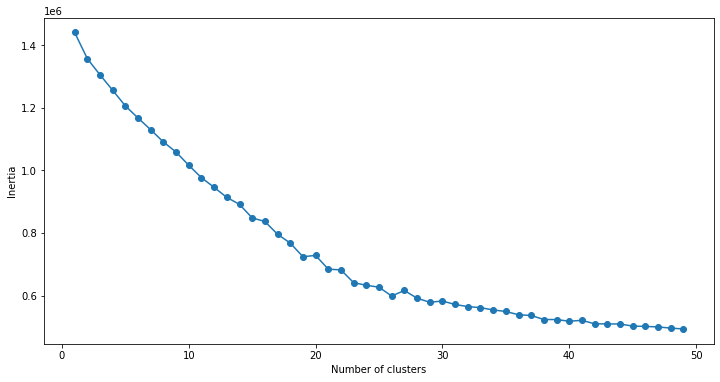

In [51]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,50):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(tdm_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,50), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [53]:
# Defining the K-means cluster with centroid initialization using Kmeans++. 
# Kmeans++ helps in finding an optimized imitial centroid.
kmeans2 = KMeans(n_clusters = 23, init ='k-means++')
kmeans2.fit(tdm_scaled)                                          # Fit scaled data in Kmeans algorithm

KMeans(n_clusters=23)

In [54]:
kmeans2.inertia_

650184.233602959

The elbow occures at k = 23 and the intertia at k = 23 is 650184. This is the total number of clusters in the dataset.

# Principal Component Analysis

We currently have 30+ variables in the dataset. We now want to see whether we can reduce the dimensions so that it is easier to interpret clusters.

In [82]:
pca=PCA(n_components=23)                                 # Initialize PCA with number of components
principalComponents=pca.fit_transform(tdm_scaled)        # Fit with training data
principalDf=pd.DataFrame(data=principalComponents)       # Create a dataframe
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.60,-0.03,3.50,-0.94,-0.54,-0.88,-0.13,-0.12,1.32,0.11,...,0.41,0.03,-0.10,-0.08,0.13,0.14,-0.49,-0.18,-0.33,0.08
1,-2.17,1.90,-0.06,1.17,0.39,-1.31,0.30,-0.15,0.78,0.37,...,0.31,-0.02,-0.11,-0.19,0.55,0.34,-0.77,-0.60,0.32,0.15
2,-2.18,-0.34,0.96,-0.90,-0.86,-0.17,-1.38,-1.55,-0.36,0.24,...,-1.34,-0.42,-2.25,0.08,-0.58,-0.21,2.28,0.45,1.39,-1.37
3,-2.03,-1.01,2.66,-0.19,-0.16,1.21,1.15,2.82,-0.46,0.03,...,0.07,0.12,0.10,0.17,0.48,0.08,-0.44,-0.44,-0.51,1.06
4,-0.73,1.12,1.93,3.59,1.40,4.37,2.79,4.27,-1.00,1.19,...,2.01,0.82,3.20,0.53,0.22,0.46,-2.43,0.18,2.96,-4.42


In [83]:
pca.explained_variance_ratio_                 # Get percentage explained value for each principal component

array([0.07445064, 0.06389086, 0.05504755, 0.0457614 , 0.04101336,
       0.03862569, 0.03708491, 0.03593419, 0.03282187, 0.03173509,
       0.03130772, 0.03118258, 0.02961049, 0.02915454, 0.02898882,
       0.02876742, 0.02819299, 0.02794006, 0.02768792, 0.02728425,
       0.02692807, 0.02544978, 0.02435645])

In [87]:
pca.explained_variance_ratio_.sum()            # Total percentage explained by 23 principal components

0.8232166375542591

Text(0, 0.5, 'Percentage Variance Explained')

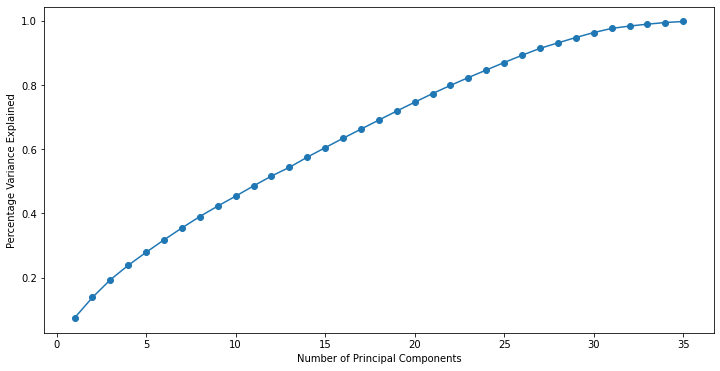

In [86]:
# Generate variance explained for multiple values of principal components and storing the values in an empty list
perc_var_exp = []
for n_component in range(1,36):
    pca2=PCA(n_components = n_component) 
    principalComponents=pca2.fit_transform(tdm_scaled) 
    principalDf=pd.DataFrame(data=principalComponents) 
    perc_var_exp.append(pca2.explained_variance_ratio_.sum())
    
# converting the results into a dataframe and plotting them
frame2 = pd.DataFrame({'Principal_Components':range(1,36), 'Percentage_Variance_Explained': perc_var_exp})
plt.figure(figsize=(12,6))
plt.plot(frame2['Principal_Components'], frame2['Percentage_Variance_Explained'], marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage Variance Explained')

23 principal components are required to explain 82.32 % of variance in the dataset.

# Conclusion

The objective of the project was to predict whether a customer will subscribe to a term deposit. Since we want to make sure that we don't miss out on revenue from incorrectly classified people who will actually subscribe, hence we chose the evaluation metric as Recall for class 1. Using Stochaistic Gradient Descent, we got the maximum recall of 82% for class 1. 

Using feature importance, we note that duration and balance are the most important features which make the customer subscribe to a term deposit. That is, longer the last call with a potential subscriber and higher the balance, greater the chances for that person subscribing to a term deposit.

Using K-means clustering, we see that there are 23 different groups of people in the dataset. Hence, it is difficult to analyze which groups of people are likely to subscribe to a term deposit.

23 principal components are required to explain 82.32 % of variance in the dataset. That is, it is not possible to reduce the dimension significantly for this dataset.